In [ ]:
!sudo yum install -y mesa-libGL

In [2]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
!ls yolo11x_custom.pt

yolo11x_custom.pt


In [4]:
import torch_neuronx
import torch
import ultralytics

batch_size = 1
imgsz = (640, 640)
im = torch.zeros(batch_size, 3, *imgsz).to('cpu')  # mock input

# Compiler options
half = True  # fp16
fp8 = False
dynamic = False  # dynamic batch

f = 'yolo11x_neuronx.pt'  # output model name
neuronx_cc_args = ['--auto-cast', 'none']

if half:
    neuronx_cc_args = ['--auto-cast', 'all', '--auto-cast-type', 'fp16']
elif fp8:
    neuronx_cc_args = ['--auto-cast', 'all', '--auto-cast-type', 'fp8_e4m3']

model = torch.load('yolo11x_custom.pt')['model']

for m in model.modules():
    if hasattr(m, 'inplace'):
        m.inplace = False
        
model.eval()
model.float()
model = model.fuse()
neuronx_model = torch_neuronx.trace(
    model,
    example_inputs=im,
    compiler_args=neuronx_cc_args,
)

if dynamic:
    neuronx_model = torch_neuronx.dynamic_batch(neuronx_model)

neuronx_model.save(f)

YOLO11x summary (fused): 464 layers, 56,839,729 parameters, 0 gradients, 194.5 GFLOPs
2024-11-24 10:14:10.000685:  8049  INFO ||NEURON_CACHE||: Compile cache path: /var/tmp/neuron-compile-cache
2024-11-24 10:14:10.000686:  8049  INFO ||NEURON_CC_WRAPPER||: Using a cached neff at /var/tmp/neuron-compile-cache/neuronxcc-2.15.143.0+e39249ad/MODULE_12029011473426652319+d7517139/model.neff. Exiting with a successfully compiled graph.
2024-11-24 10:14:10.000693:  8049  INFO ||NEURON_CACHE||: Compile cache path: /var/tmp/neuron-compile-cache
2024-11-24 10:14:10.000694:  8049  INFO ||NEURON_CC_WRAPPER||: Using a cached neff at /var/tmp/neuron-compile-cache/neuronxcc-2.15.143.0+e39249ad/MODULE_10496201408156804367+d7517139/model.neff. Exiting with a successfully compiled graph.
2024-11-24 10:14:10.000699:  8049  INFO ||NEURON_CACHE||: Compile cache path: /var/tmp/neuron-compile-cache
2024-11-24 10:14:10.000700:  8049  INFO ||NEURON_CC_WRAPPER||: Using a cached neff at /var/tmp/neuron-compile-ca

In [5]:
# Load the compiled model
model_n = torch.jit.load('yolo11x_neuronx.pt')

In [6]:
import os
import cv2
import torch
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from torchvision import transforms
from ultralytics import YOLO
import torch_neuronx
import torch
from ultralytics.utils import ops

img_size=640
# load an image
img = cv2.imread('m.jpg')
h,w,c = img.shape
factor = img_size/w
new_h = int(h*factor)
# build a squared tensor
x = np.zeros((w,w,c), dtype=np.uint8)
x[:h, :w] = img[:]
x = cv2.cvtColor(cv2.resize(x, (640,640)), cv2.COLOR_BGR2RGB)
x = x.transpose(2,0,1).astype(np.float32) / 255.0
x = torch.from_numpy(np.expand_dims(x, axis=0))

# invoke the model and post-process the predictions
y = model_n(x)
preds = ops.non_max_suppression(y)
print(preds)
#prediction = torch.tensor(preds)
#print(prediction)

[tensor([[282.9645, 195.3220, 368.2021, 388.3385,   0.8567,   4.0000]])]


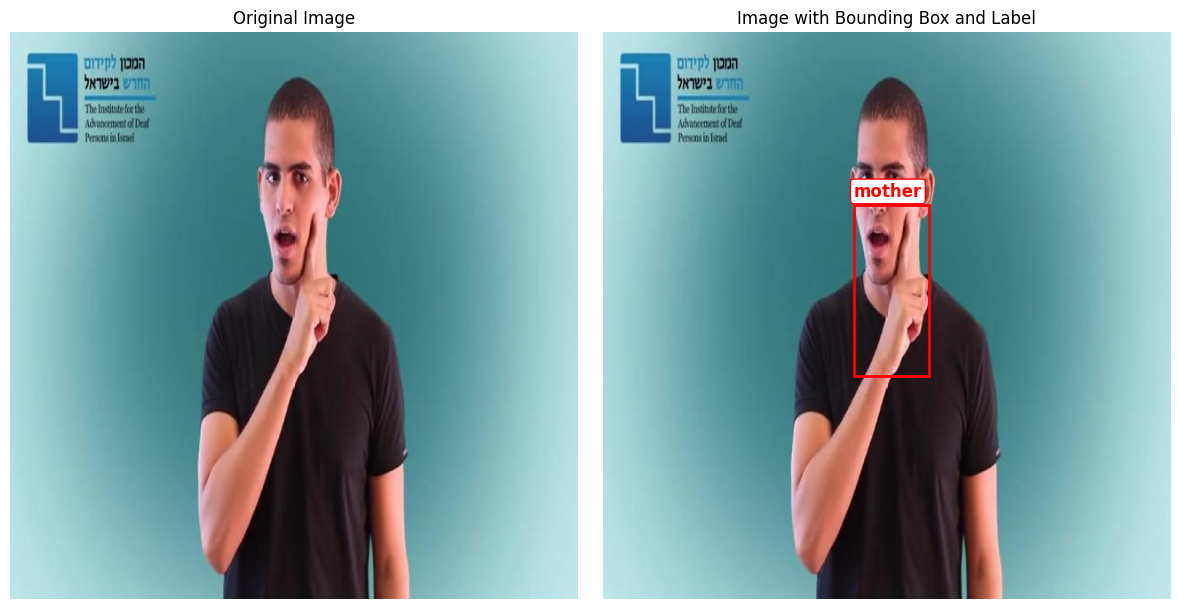

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Image path
image_path = "m.jpg"  # Replace with your image file path

# Load the image
image = Image.open(image_path)

# Bounding box coordinates from the list (x_min, y_min, x_max, y_max)
bbox = preds[0].flatten().tolist()[:-1]
label = "mother"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Original image
axes[0].imshow(image)
axes[0].axis('off')  # Remove axes
axes[0].set_title("Original Image")

# Subplot 2: Image with bounding box and label
axes[1].imshow(image)

# Create a rectangle patch for the bounding box
rect = patches.Rectangle(
    (bbox[0], bbox[1]),             # Bottom-left corner (x_min, y_min)
    bbox[2] - bbox[0],              # Width (x_max - x_min)
    bbox[3] - bbox[1],              # Height (y_max - y_min)
    linewidth=2,                    # Line thickness
    edgecolor='red',                # Color of the rectangle
    facecolor='none'                # Transparent fill
)

# Add the rectangle to the second plot
axes[1].add_patch(rect)

# Add label above the bounding box
axes[1].text(
    bbox[0], bbox[1] - 10,          # Position: slightly above top-left corner
    label,                          # Text content
    color='red',                    # Text color
    fontsize=12,                    # Font size
    weight='bold',                  # Bold text
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')  # Background styling
)

axes[1].axis('off')  # Remove axes
axes[1].set_title("Image with Bounding Box and Label")

# Show the plots
plt.tight_layout()
plt.show()
